# Setup libraries

In [374]:
import spacy
import numpy as np
import pandas as pd
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import random
import gc
%matplotlib inline

# Setup important variables

In [375]:
subsample = 1000 # Use a subsample of the data
nlp = spacy.load('en')
path_inputs = os.path.join('data', 'cases')
path_labels = os.path.join('data')
filenames = random.sample([filename for filename in os.listdir(path_inputs)], subsample)

# Parse all documents once and store parsed versions

In [376]:
parsed_docs = []
for filename in filenames:
    with open(os.path.join(path_inputs, filename)) as f:
        doc = nlp(f.read())
        parsed_docs.append(doc)

# Normalizing corpus

We remove punctuation as well as whitespace as they are not useful in creating trigrams.
We also remove stop words as they don't change the context we want to capture with trigrams.
We also use lemmatization to match different inflectional forms of the the same words without changing the part of speech of the word.

In [377]:
# Count occurences of each normalized trigram that ends in a noun
trigram_count = {}
# Indices
LEMMA = 0
POS = 1 # part-of-speech

for doc in parsed_docs:
    toks = [(token.lemma_, token.pos_) for token in doc if not token.is_space if not token.is_punct if not token.is_stop]
    for i in range(len(toks)):
        if i < 2:
            continue # start from 3rd token
        pos = toks[i][POS]
        if (pos == 'NOUN'):
            trigram = (toks[i][LEMMA], toks[i - 1][LEMMA], toks[i - 2][LEMMA])
            if trigram in trigram_count:
                trigram_count[trigram] += 1
            else:
                trigram_count[trigram] = 1

# Select top 1000 trigrams as features

In [378]:
TOP = 1000
# sort descending by the value(count) and select the first TOP as the features
top_trigrams, _ = map(list, zip(*(sorted(list(trigram_count.items()), key=lambda x: -x[1])[:TOP])))

In [379]:
# Manually free memory
del trigram_count
gc.collect(2)

23890

# Create a dataframe using the 1000 trigram features for each document

In [380]:
# Extract case names
cases = sorted(list(([filename[5:-4] for filename in filenames])))

# Dataframe to hold counts for each trigram feature
dfTRI = pd.DataFrame(np.zeros((len(cases), len(top_trigrams))), index=cases, columns=top_trigrams).astype(np.int64)

for filenameidx, doc in enumerate(parsed_docs):
    toks = [(token.lemma_, token.pos_) for token in doc if not token.is_space if not token.is_punct if not token.is_stop]
    for i in range(len(toks)):
        if i < 2:
            continue # start from 3rd token
        pos = toks[i][POS]
        if (pos == 'NOUN'):
            trigram = (toks[i][LEMMA], toks[i - 1][LEMMA], toks[i - 2][LEMMA])
            if trigram in top_trigrams:
                dfTRI.at[filenames[filenameidx][5:-4], trigram] += 1
                

In [381]:
# Manually free memory
del parsed_docs
gc.collect(2)

0

# Normalize the dataframe to have unit variance per feature
We keep me the mean as it is in order to maintain spasity

In [382]:
dfTRI_normalized = dfTRI / dfTRI.std()

# Load case_reversed.csv

In [383]:
df_reverse = pd.read_csv(os.path.join(path_labels, 'case_metadata.csv')).set_index('caseid').loc[cases]

# Split train and test data, apply logistic regression and print accuracy and F1 score

In [384]:
X_train, X_test, y_train, y_test = train_test_split(dfTRI_normalized, df_reverse, test_size=0.15)
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train.case_reversed)
y_pred = clf.predict(X_test)

print('F1 score: {}'.format(f1_score(y_test.case_reversed, y_pred)))
print('Accuracy score {}'.format(accuracy_score(y_test.case_reversed, y_pred)))

F1 score: 0.6596858638743455
Accuracy score 0.5666666666666667


# GridsearchCV to choose l1 vs l2 penalty and regularization parameter C

In [385]:
from sklearn.model_selection import GridSearchCV
parameters = {'penalty':('l1', 'l2'), 'C':[0.1, 2]}
logistic = LogisticRegression(solver='liblinear')
clf = GridSearchCV(logistic, parameters, cv=5, iid=True)
clf.fit(X_train, y_train.case_reversed)
print("The model selected is:")
print(clf.get_params()['estimator'])
print()
print("Training score: {}".format(clf.score(X_train, y_train.case_reversed)))
print("Test score: {}".format(clf.score(X_test, y_test.case_reversed)))

The model selected is:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

Training score: 0.8070588235294117
Test score: 0.5866666666666667


# Cross validated prediction for each observation

In [386]:
y_pred = sklearn.model_selection.cross_val_predict(clf, dfTRI_normalized, df_reverse.case_reversed, cv=3)
y_predict_proba = sklearn.model_selection.cross_val_predict(clf, dfTRI_normalized, df_reverse.case_reversed, cv=3, method='predict_proba')
y_predict_proba = y_predict_proba[:,1] # probability to be 1

# Confusion matrix

In [387]:
y_true = df_reverse.case_reversed
sklearn.metrics.confusion_matrix(y_true, y_pred)

array([[ 59, 324],
       [ 85, 532]])

# roc_curve()

AUC:  0.5190448180575598


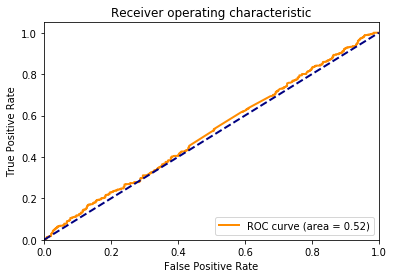

In [388]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_true, y_predict_proba)
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# precision_recall_curve()

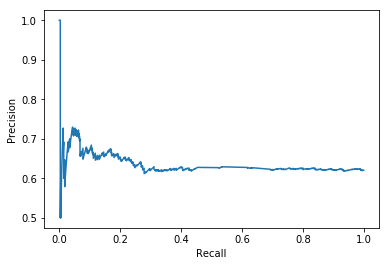

In [389]:
(precision, recall, threshold) = sklearn.metrics.precision_recall_curve(y_true, y_predict_proba)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall, precision)

# Calibration plot

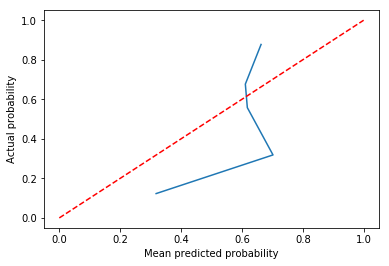

In [390]:
import sklearn.calibration
prob_pred, prob_true = sklearn.calibration.calibration_curve(y_true, y_predict_proba)
plt.xlabel('Mean predicted probability')
plt.ylabel('Actual probability')
plt.plot(prob_pred, prob_true)
plt.plot([0,1], [0,1], color='red', linestyle='--')

# n-gram frequencies are already normalized to have unit variance per feature. We kept the mean to its current value to maintain sparsity
dfTRI_normalized = dfTRI / dfTRI.std()

# Training an elastic net model to predict log citations

In [391]:
regr = sklearn.linear_model.ElasticNet()
# Clear data from NaNs
X_pre = dfTRI_normalized
y_pre = df_reverse.log_cites
y = y_pre.dropna(axis=0) # drop all NaN outputs
X = X_pre[X_pre.index.isin(y.index)] # drop all indexes that have NaN outputs
# Model selection
y_pred = sklearn.model_selection.cross_val_predict(
    regr, X, y=y, cv=5
)

# Scatter plot of true and predicted values

Text(0,0.5,'Predicted y')

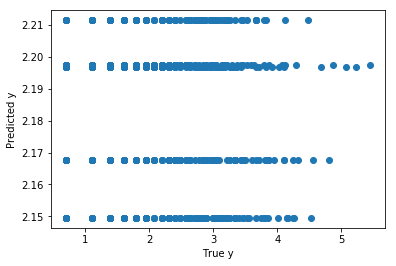

In [392]:
plt.plot(y, y_pred, 'o')
plt.xlabel('True y')
plt.ylabel('Predicted y')

# Use judge identifier to produce average citations to case for each judge

In [393]:
X = df_reverse
X = X.dropna(subset=['judge_id', 'log_cites'])
jdf = X.groupby(by='judge_id')
jdf = jdf['log_cites'].agg(np.mean)
X['avg_log_cites'] = (X['judge_id']).apply(lambda judge: jdf[judge])

/anaconda3/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


# Predict case reverse with a 2-stage LS model

In [394]:
from linearmodels.iv import IV2SLS

formula_fs = 'case_reversed ~ 1 + C(year) + [log_cites ~ avg_log_cites]'
fs = IV2SLS.from_formula(formula_fs, data=X)
results_fs = fs.fit()
results_fs

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:          case_reversed   R-squared:                      0.1652
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0513
No. Observations:                 742   F-statistic:                    6512.4
Date:                Sat, Apr 06 2019   P-value (F-stat)                0.0000
Time:                        21:12:49   Distribution:                 chi2(89)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept             1.0353     0.0264     39.241     0.0000      0.9836      1.0871
C(year)[T.1926.0]    -0.7403     0.2195    -3.3735     0.0007     -1.1704     -0.3102
C(year)[T.1927.0]    -0.1432     0.1604    -0.8928     0.3720     -0.4575      0.1711
C(year)[T.1928.0]     0.0222     0.0185     1.1998     0.2302     -0.0141      0.0584
C(year)[T.1929.0]    -0.4899     0.3409    -1.4372     0.1507     -1.1581      0.1782
C(year)[T.1930.0]    -0.2262     0.2101    -1.0767     0.2816     -0.6381      0.1856
C(year)[T.1931.0]     0.0474     0.0354     1.3399     0.1803     -0.0219      0.1167
C(year)[T.1932.0]    -0.6399     0.1931    -3.3145     0.0009     -1.0183     -0.2615
C(year)[T.1933.0]    -0.5681     0.1875    -3.0301     0.0024     -0.9355     -0.2006
C(year)[T.1934.0]    -0.7698     0.1756    -4.3831     0.0000     -1.1141     -0.4256
C(year)[T.1935.0]    -0.5398     0.1835    -2.9419     0.0033     -0.8994     -0.1802
C(year)[T.1936.0]    -0.5965     0.1737    -3.4335     0.0006     -0.9371     -0.2560
C(year)[T.1937.0]    -0.4242     0.1835    -2.3111     0.0208     -0.7839     -0.0644
C(year)[T.1938.0]    -0.5910     0.1709    -3.4587     0.0005     -0.9259     -0.2561
C(year)[T.1939.0]    -0.2627     0.1463    -1.7960     0.0725     -0.5494      0.0240
C(year)[T.1940.0]    -0.5207     0.1374    -3.7891     0.0002     -0.7901     -0.2514
C(year)[T.1941.0]    -0.2714     0.1309    -2.0728     0.0382     -0.5280     -0.0148
C(year)[T.1942.0]    -0.6262     0.1576    -3.9725     0.0001     -0.9351     -0.3172
C(year)[T.1943.0]    -0.5221     0.1639    -3.1848     0.0014     -0.8434     -0.2008
C(year)[T.1944.0]    -0.2007     0.1210    -1.6582     0.0973     -0.4378      0.0365
C(year)[T.1945.0]    -0.4824     0.1582    -3.0499     0.0023     -0.7923     -0.1724
C(year)[T.1946.0]    -0.6360     0.1367    -4.6532     0.0000     -0.9039     -0.3681
C(year)[T.1947.0]    -0.7622     0.1809    -4.2135     0.0000     -1.1168     -0.4077
C(year)[T.1948.0]    -0.2956     0.1585    -1.8656     0.0621     -0.6062      0.0150
C(year)[T.1949.0]    -0.2772     0.2649    -1.0466     0.2953     -0.7963      0.2419
C(year)[T.1950.0]    -0.4427     0.1594    -2.7774     0.0055     -0.7552     -0.1303
C(year)[T.1951.0]    -0.2868     0.2723    -1.0534     0.2922     -0.8205      0.2469
C(year)[T.1952.0]    -0.1270     0.1550    -0.8191     0.4127     -0.4309      0.1769
C(year)[T.1953.0]    -0.4364     0.1796    -2.4299     0.0151     -0.7883     -0.0844
C(year)[T.1954.0]    -0.1587     0.1619    -0.9803     0.3269     -0.4759      0.1586
C(year)[T.1955.0]    -0.3896     0.1425    -2.7336     0.0063     -0.6690     -0.1103
C(year)[T.1956.0]    -0.5402     0.1460    -3.6991     0.0002     -0.8264     -0.2540
C(year)[T.1957.0]    -0.5864     0.1493    -3.9264     0.0001     -0.8791     -0.2937
C(year)[T.1958.0]     0.0364     0.0284     1.2813     0.2001     -0.0193      0.0922
C(year)[T.1959.0]    -0.3150     0.1441    -2.1

# LDA

# Load the texts of the cases and extract features for LDA

In [395]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Load cases
data_samples = []
for filename in filenames:
    with open(os.path.join(path_inputs, filename)) as f:
        data_samples.append(f.read())
        
# Extract tf features for LDA
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=10000,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)
tf_feature_names = tf_vectorizer.get_feature_names()

# Top words of each topic
def get_top_words(model, feature_names, n_top_words):
    words = {}
    for topic_idx, topic in enumerate(model.components_):
        words[topic_idx] = {}
        tmp = [(feature_names[i], topic[i]) for i in topic.argsort()[:-n_top_words - 1:-1]]
        for f, c in tmp:
            words[topic_idx][f] = c
    return words

# 5 topics

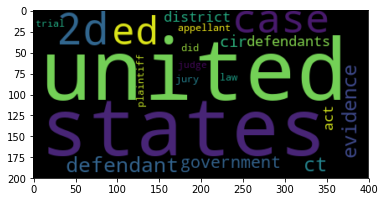

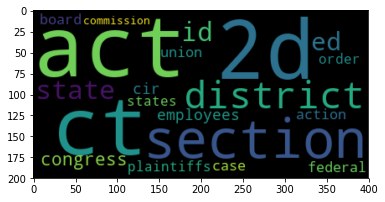

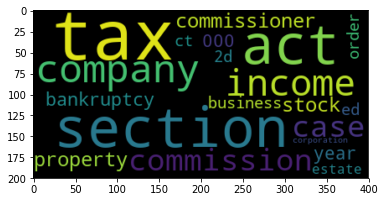

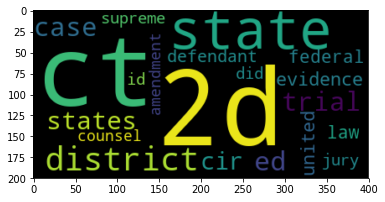

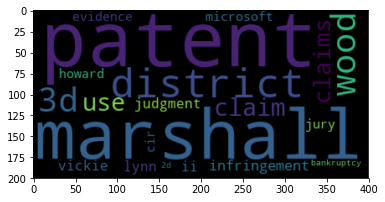

In [396]:
from wordcloud import WordCloud

# 5 topics
n_components = 5
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

tf = tf_vectorizer.fit_transform(data_samples)
lda.fit(tf)

n_top_words = 20
top_words = get_top_words(lda, tf_feature_names, n_top_words)
for topic_idx in range(0, n_components):
    wordcloud = WordCloud().generate_from_frequencies(top_words[topic_idx])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

# 10 topics

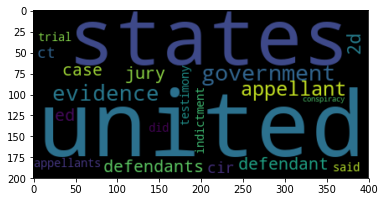

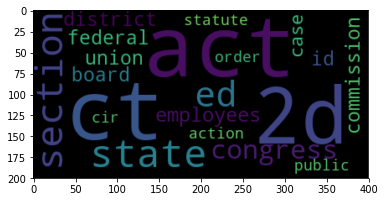

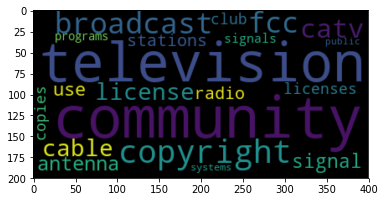

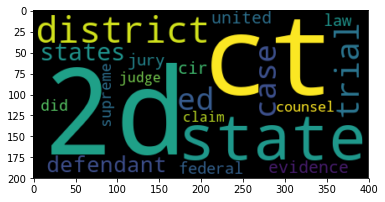

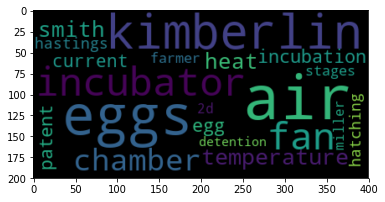

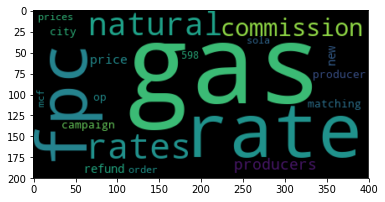

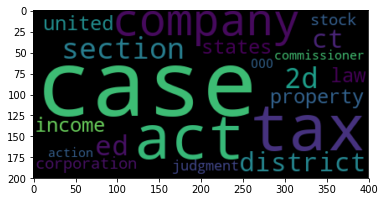

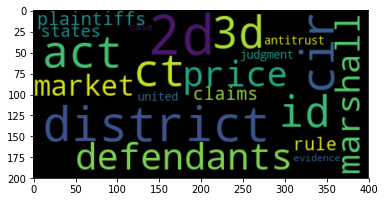

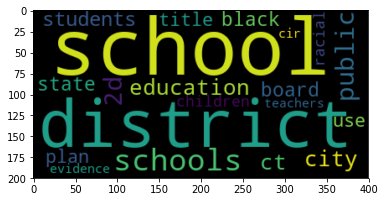

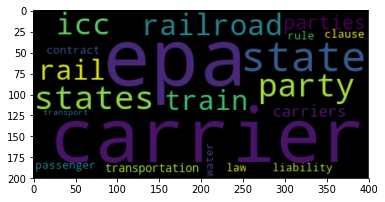

In [397]:
from wordcloud import WordCloud

# 10 topics
n_components = 10
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

tf = tf_vectorizer.fit_transform(data_samples)
lda.fit(tf)

n_top_words = 20
top_words = get_top_words(lda, tf_feature_names, n_top_words)
for topic_idx in range(0, n_components):
    wordcloud = WordCloud().generate_from_frequencies(top_words[topic_idx])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()
    

# 20 topics

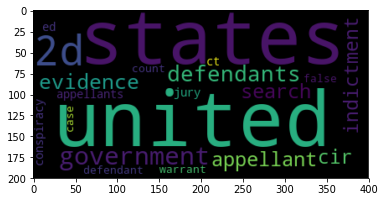

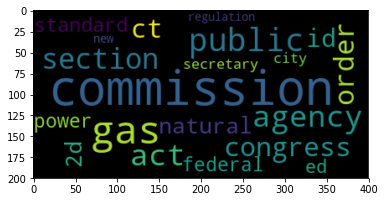

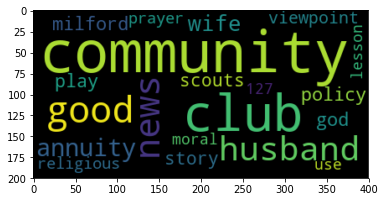

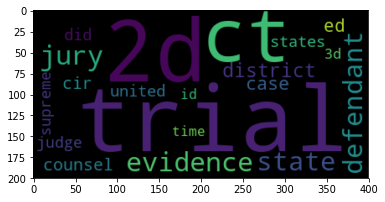

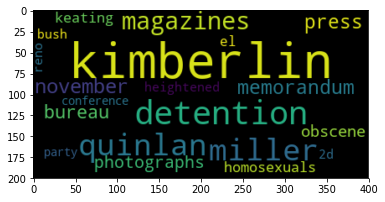

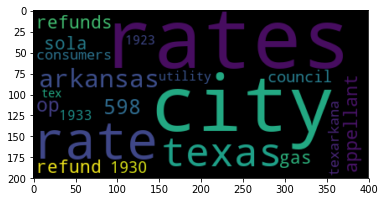

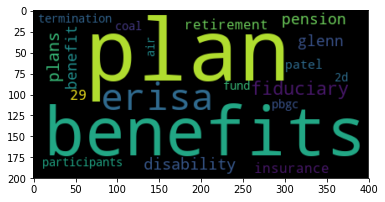

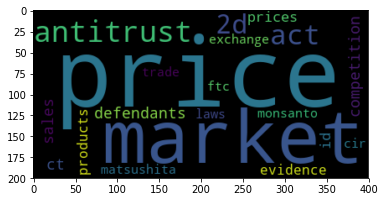

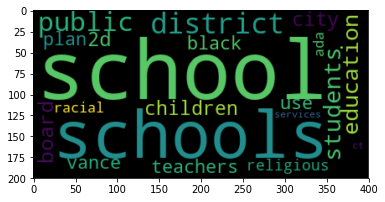

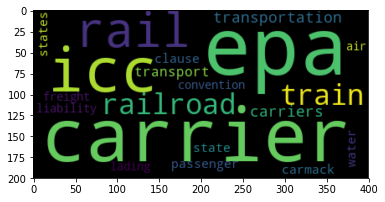

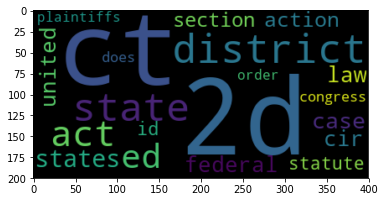

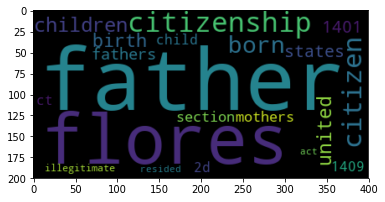

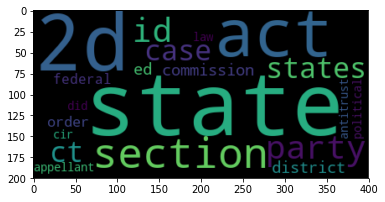

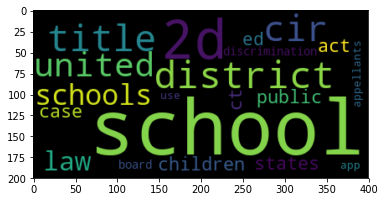

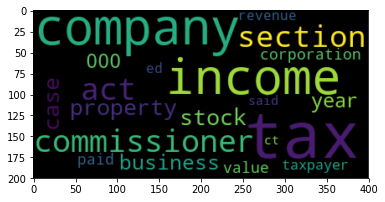

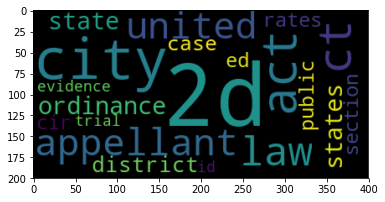

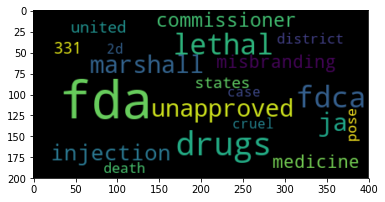

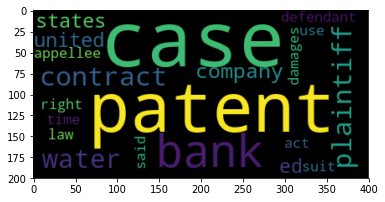

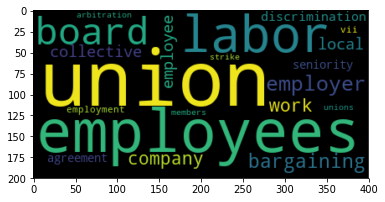

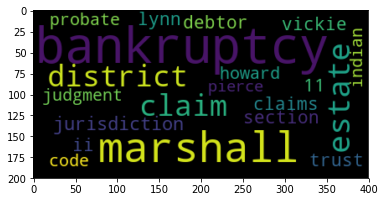

In [398]:
from wordcloud import WordCloud

# 20 topics
n_components = 20
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

tf = tf_vectorizer.fit_transform(data_samples)
lda.fit(tf)

n_top_words = 20
top_words = get_top_words(lda, tf_feature_names, n_top_words)
for topic_idx in range(0, n_components):
    wordcloud = WordCloud().generate_from_frequencies(top_words[topic_idx])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()
    

# Linear regression model implemented in tensorflow

In [399]:
import tensorflow as tf

SEED = 42
np.random.seed(SEED) # make result reproducible
NUM_TRAIN_STEPS = 10001 # How many steps to train for
BATCH_SIZE = 32
LEARNING_RATE = 0.0025

# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(dfTRI_normalized, df_reverse.case_reversed, test_size=0.15)
NUM_FEATURES = len(x_train.columns)
num_train_entries = len(x_train.index)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

# Reset computational graph
tf.reset_default_graph()
session = tf.Session()

# Define linear regression model
input_tensor = tf.placeholder(tf.float32, (BATCH_SIZE, NUM_FEATURES))
label_tensor = tf.placeholder(tf.float32, (BATCH_SIZE, 1)) # 1 output in this case
logits = tf.layers.dense(
    inputs=input_tensor,
    units=1,
    use_bias=True,
    name="dense_layer",
)
output_tensor = tf.contrib.layers.softmax(logits=logits)

# Define a mean-squared-error loss function + L2 regularization
beta = 0.01
weights = tf.trainable_variables()[0] 
regularizer = tf.nn.l2_loss(weights)
loss_tensor = tf.reduce_mean(tf.squared_difference(output_tensor, label_tensor))

# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
optimize_op = optimizer.minimize(loss_tensor)

# Train model
session.run(tf.global_variables_initializer())

for i in range(NUM_TRAIN_STEPS):
    
    # Draw random samples from train data for batch GD
    indices = sorted(np.random.choice(num_train_entries, size=BATCH_SIZE, replace=False))

    # Run update step and simultaneously calculate training loss
    training_loss, _ = session.run(
        [loss_tensor, optimize_op], 
        feed_dict={
            input_tensor: x_train[indices, :],
            label_tensor: y_train[indices, :],
        }
    )
    
    if i % 500 == 0:
        print('Step %04d> training loss: %.2f' % (i, training_loss))

Step 0000> training loss: 0.25
Step 0500> training loss: 0.28
Step 1000> training loss: 0.47
Step 1500> training loss: 0.44
Step 2000> training loss: 0.34
Step 2500> training loss: 0.41
Step 3000> training loss: 0.34
Step 3500> training loss: 0.41
Step 4000> training loss: 0.38
Step 4500> training loss: 0.44
Step 5000> training loss: 0.31
Step 5500> training loss: 0.28
Step 6000> training loss: 0.31
Step 6500> training loss: 0.19
Step 7000> training loss: 0.38
Step 7500> training loss: 0.50
Step 8000> training loss: 0.38
Step 8500> training loss: 0.41
Step 9000> training loss: 0.31
Step 9500> training loss: 0.25
Step 10000> training loss: 0.47


# Evaluate on test set

In [400]:
num_test_entries = x_test.shape[0]
NUM_TEST_STEPS = 100
total_loss = 0

for i in range(NUM_TEST_STEPS):
    # Draw random samples from test data for evaluation
    indices = sorted(np.random.choice(num_test_entries, size=BATCH_SIZE, replace=True))

    test_loss = session.run(
        loss_tensor, 
        feed_dict={
            input_tensor: x_test[indices, :],
            label_tensor: y_test[indices, :],
        }
    )
    total_loss += test_loss
    
print('Total test loss: %.2f' % (total_loss / NUM_TEST_STEPS))

Total test loss: 0.39


#  Add two hidden layers, dropout, and batch normalization.

In [401]:
import tensorflow as tf

SEED = 42
np.random.seed(SEED) # make result reproducible
NUM_TRAIN_STEPS = 10001 # How many steps to train for
BATCH_SIZE = 32
LEARNING_RATE = 0.0025

# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(dfTRI_normalized, df_reverse.case_reversed, test_size=0.15)
NUM_FEATURES = len(x_train.columns)
num_train_entries = len(x_train.index)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

# Reset computational graph
tf.reset_default_graph()
session = tf.Session()

# Define linear regression model
input_tensor = tf.placeholder(tf.float32, (BATCH_SIZE, NUM_FEATURES))
label_tensor = tf.placeholder(tf.float32, (BATCH_SIZE, 1)) # 1 output in this case
first = tf.layers.dense(
    inputs=input_tensor,
    units=256,
    use_bias=True,
    name="dense_layer_1",
)
bn1 = tf.layers.batch_normalization(first)
drop = tf.nn.dropout(bn1, keep_prob=0.5)
second = tf.layers.dense(
    inputs=input_tensor,
    units=64,
    use_bias=True,
    name="dense_layer_2",
)
bn2 = tf.layers.batch_normalization(second)
logits = tf.layers.dense(
    inputs=input_tensor,
    units=1,
    use_bias=True,
    name="output_layer",
)
output_tensor = tf.contrib.layers.softmax(logits=logits)

# Define a mean-squared-error loss function + L2 regularization
beta = 0.01
weights = tf.trainable_variables()[0] 
regularizer = tf.nn.l2_loss(weights)
loss_tensor = tf.reduce_mean(tf.squared_difference(output_tensor, label_tensor))

# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
optimize_op = optimizer.minimize(loss_tensor)

# Train model
session.run(tf.global_variables_initializer())

for i in range(NUM_TRAIN_STEPS):
    
    # Draw random samples from train data for batch GD
    indices = sorted(np.random.choice(num_train_entries, size=BATCH_SIZE, replace=False))

    # Run update step and simultaneously calculate training loss
    training_loss, _ = session.run(
        [loss_tensor, optimize_op], 
        feed_dict={
            input_tensor: x_train[indices, :],
            label_tensor: y_train[indices, :],
        }
    )
    
    if i % 500 == 0:
        print('Step %04d> training loss: %.2f' % (i, training_loss))

Step 0000> training loss: 0.25
Step 0500> training loss: 0.28
Step 1000> training loss: 0.47
Step 1500> training loss: 0.44
Step 2000> training loss: 0.34
Step 2500> training loss: 0.41
Step 3000> training loss: 0.34
Step 3500> training loss: 0.41
Step 4000> training loss: 0.38
Step 4500> training loss: 0.44
Step 5000> training loss: 0.31
Step 5500> training loss: 0.28
Step 6000> training loss: 0.31
Step 6500> training loss: 0.19
Step 7000> training loss: 0.38
Step 7500> training loss: 0.50
Step 8000> training loss: 0.38
Step 8500> training loss: 0.41
Step 9000> training loss: 0.31
Step 9500> training loss: 0.25
Step 10000> training loss: 0.47


# Evaluate on test set

In [402]:
num_test_entries = x_test.shape[0]
NUM_TEST_STEPS = 100
total_loss = 0

for i in range(NUM_TEST_STEPS):
    # Draw random samples from test data for evaluation
    indices = sorted(np.random.choice(num_test_entries, size=BATCH_SIZE, replace=True))

    test_loss = session.run(
        loss_tensor, 
        feed_dict={
            input_tensor: x_test[indices, :],
            label_tensor: y_test[indices, :],
        }
    )
    total_loss += test_loss
    
print('Total test loss: %.2f' % (total_loss / NUM_TEST_STEPS))

Total test loss: 0.39
